# Eurovision Song Contest:  Strategic Voting Analysis

### Data Source: https://data.world/datagraver/eurovision-song-contest-scores-1975-2018


# Research Questions

    1)Do countries vote tactically? 
        Detect strategic voting patterns between countries in Eurovision Song Contest.
        
    2) Is tactical voting getting worse? 
        Detect changes in volume / density of strategic behavour over time.

# Approaches explored

### 1. Network analysis and Jaccard Similarity

#### Bi-Direcitonal, Weighted Network of Countries and Votes
Original approach for a given time windows (e.g. 5 years), map semi-final and finalist countries as nodes in a network. Edges were bi-directional and wieghted according to the number of votes given and recieved between thos countried in that time period.

#### Community detection: Louvain Modularity 
Community detection using Louvain Modularity applied to the networks for given time span

#### Detect changes in communities: Jaccard Similarity
A rolling comparison between detected communities for each time window. Each community for the current year is martched to its closest community from the last year (closeness being measured as the one with the highest jaccard index). The overall average similarity score is then a wieghed Jaccard score: sum (Jaccard of best match * size of community) / sum(size of all communities)

### 2. Montecarlo Simulations

##### Montecarlo simulation of expected votes based on non-biased sampling of possible votes distributinos each year
Approach adatped from: Derek Gatherer(2006) Comparison of Eurovision Song Contest Simulation with Actual Results Reveals Shifting Patterns of Collusive Voting Alliances. Journal of Artificial Societies and Social Simulation vol. 9, no. 2 http://jasss.soc.surrey.ac.uk/9/2/1.html

####  Compare non-biased expectation value to actual results
Where actual votes given/recieved falls within the 90% centile, the vote is consider suspceouse. 
Where suspicouse votes are given and recieved between two countries an 'alliance' is considered have been detected

#### Visualise alliances as networks
For all detected alliances, map the alliances.

#### Dectect changes over time
Measure changes in volume of alliances and countries in alliances over time.



In [87]:
%matplotlib inline
import pandas as pd
data_folder = 'data/'
df_votes = pd.read_csv(data_folder+'votes.csv')

# Data Cleaning

In [88]:
#Netherlands miss-spelled
print(df_votes.columns)
df_votes.rename(columns={'Points      ': 'Points'},inplace=True)
df_votes['From country'] = df_votes['From country'].str.replace('The Netherands','The Netherlands')


#for 2006: sad story regarding serbia and mont: https://en.wikipedia.org/wiki/Serbia_and_Montenegro_in_the_Eurovision_Song_Contest_2006

to_drop = df_votes[df_votes['Year']==2006][df_votes['From country'] == 'Serbia & Montenegro'].index
df_votes = df_votes.drop(to_drop)


# 2015: F R MAC
to_drop = df_votes[df_votes['Year']==2015][df_votes['From country'] == 'F.Y.R. Macedonia'].index
df_votes = df_votes.drop(to_drop)


# I am only going to work with voting in the finals for now...




Index(['Year', '(semi-) final', 'Edition', 'Jury or Televoting',
       'From country', 'To country', 'Points      ', 'Duplicate'],
      dtype='object')


/Users/garethwalker/anaconda3/envs/eurovis/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/garethwalker/anaconda3/envs/eurovis/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


# EDA

In [89]:
df_votes.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


In [90]:
df_votes['(semi-) final'].unique()

array(['f', 'sf', 'sf1', 'sf2'], dtype=object)

In [91]:
df_votes['Points'].unique()

array([ 0,  2, 12,  1,  6,  7,  4,  8,  3, 10,  5])

In [92]:
df_votes['Year'].unique()

array([1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [93]:
df_votes['From country'].unique()

array(['Belgium', 'Finland', 'France', 'Germany', 'Ireland', 'Israel',
       'Italy', 'Luxembourg', 'Malta', 'Monaco', 'Norway', 'Portugal',
       'Spain', 'Sweden', 'Switzerland', 'The Netherlands', 'Turkey',
       'United Kingdom', 'Yugoslavia', 'Austria', 'Greece', 'Denmark',
       'Morocco', 'Cyprus', 'Iceland', 'Bosnia & Herzegovina', 'Croatia',
       'Slovenia', 'Estonia', 'Hungary', 'Lithuania', 'Poland', 'Romania',
       'Russia', 'Slovakia', 'F.Y.R. Macedonia', 'Latvia', 'Ukraine',
       'Albania', 'Andorra', 'Belarus', 'Serbia & Montenegro', 'Bulgaria',
       'Moldova', 'Armenia', 'Czech Republic', 'Georgia', 'Montenegro',
       'Serbia', 'Azerbaijan', 'San Marino', 'Australia', 'Macedonia'],
      dtype=object)

In [94]:
df_votes['To country'].unique()

array(['Belgium', 'Finland', 'France', 'Germany', 'Ireland', 'Israel',
       'Italy', 'Luxembourg', 'Malta', 'Monaco', 'Norway', 'Portugal',
       'Spain', 'Sweden', 'Switzerland', 'The Netherlands', 'Turkey',
       'United Kingdom', 'Yugoslavia', 'Austria', 'Greece', 'Denmark',
       'Morocco', 'Cyprus', 'Iceland', 'Bosnia & Herzegovina', 'Croatia',
       'Slovenia', 'Estonia', 'Hungary', 'Lithuania', 'Poland', 'Romania',
       'Russia', 'Slovakia', 'F.Y.R. Macedonia', 'Latvia', 'Ukraine',
       'Albania', 'Serbia & Montenegro', 'Andorra', 'Belarus', 'Moldova',
       'Bulgaria', 'Armenia', 'Georgia', 'Serbia', 'Czech Republic',
       'Montenegro', 'Azerbaijan', 'San Marino', 'Australia', 'Macedonia'],
      dtype=object)

In [123]:
df_votes[df_votes['(semi-) final']=='f'].groupby('Year').nunique()[['From country','To country']]

,From country,To country
Year,,
1975,19,19
1976,18,18
1977,18,18
1978,20,20
1979,19,19
1980,19,19
1981,20,20
1982,18,18
1983,20,20


In [96]:
df_votes[df_votes['Year'].between(2002,2018)].groupby(['Year','(semi-) final']).nunique()

Year  (semi-) final  Edition  Jury or Televoting  \
Year (semi-) final                                                     
2002 f                 1              1        1                   1   
2003 f                 1              1        1                   1   
2004 f                 1              1        1                   1   
     sf                1              1        1                   1   
2005 f                 1              1        1                   1   
     sf                1              1        1                   1   
2006 f                 1              1        1                   1   
     sf                1              1        1                   1   
2007 f                 1              1        1                   1   
     sf                1              1        1                   1   
2008 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2009 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2010 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2011 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2012 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2013 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2014 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2015 f                 1              1        1                   1   
     sf1               1              1        1                   1   
     sf2               1              1        1                   1   
2016 f                 1              1        1                   2   
     sf1               1              1        1                   2   
     sf2               1              1        1                   2   
2017 f                 1              1        1                   2   
     sf1               1              1        1                   2   
     sf2               1              1        1                   2   
2018 f                 1              1        1                   2   
     sf1               1              1        1                   2   
     sf2               1              1        1                   2   

                    From country  To country  Points  Duplicate  
Year (semi-) final                                               
2002 f                        24          24      11          1  
2003 f                        26          26      11          1  
2004 f                        36          24      11          1  
     sf                       36          22      11          1  
2005 f                        39          24      11          1  
     sf                       39          25      11          1  
2006 f                        37          24      11          1  
     sf                       37          23      11          1  
2007 f                        42          24      11          1  
     sf                       42          28      11 

# Restrict Analysis to Finals

In [97]:
df_votes_finals = df_votes[df_votes['(semi-) final']=='f']

In [134]:
df_votes_finals[df_votes_finals['Year']==2008]

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
21264,2008,f,2008f,J,Albania,Albania,0,x
21265,2008,f,2008f,J,Albania,Armenia,2,NaN
21266,2008,f,2008f,J,Albania,Azerbaijan,0,NaN
21267,2008,f,2008f,J,Albania,Bosnia & Herzegovina,0,NaN
21268,2008,f,2008f,J,Albania,Croatia,0,NaN
21269,2008,f,2008f,J,Albania,Denmark,0,NaN
21270,2008,f,2008f,J,Albania,Finland,0,NaN
21271,2008,f,2008f,J,Albania,France,0,NaN
21272,2008,f,2008f,J,Albania,Georgia,0,NaN
21273,2008,f,2008f,J,Albania,Germany,0,NaN


# Analysis using 'community detection'

In [98]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import community

def detect_community(df, year_from, year_to):
    global selected_df
    # compile vote matrix for selected years
    selected_df = df[df['Year'].between(year_from,year_to)]
    selected_df = selected_df.groupby(['From country','To country']).Points.sum()
    selected_df = selected_df.unstack().fillna(0)
    loosers = list(set(selected_df.index)-set(selected_df.columns))
    for i in range(len(loosers)):
        selected_df[loosers[i]] = 0
        
    # convert df to graph object
    np_matrix = selected_df.values
    names = selected_df.columns
    graph = nx.from_numpy_matrix(np_matrix)
    graph = nx.relabel_nodes(graph, dict(enumerate(names)))
    
    
    # use Louvain Modularity to identify communities
    part = community.best_partition(graph)
    

    
    return graph, part

def visualise(graph, part):
    # visualise
    values = [part.get(node) for node in graph.nodes()]
    plt.figure(figsize=(20,20))
    pos=nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos, node_size=300,cmap = plt.get_cmap('jet'), node_color = values,alpha=0.5)
    nx.draw_networkx_labels(graph, pos, font_size=18, font_family='sans-serif')
    return

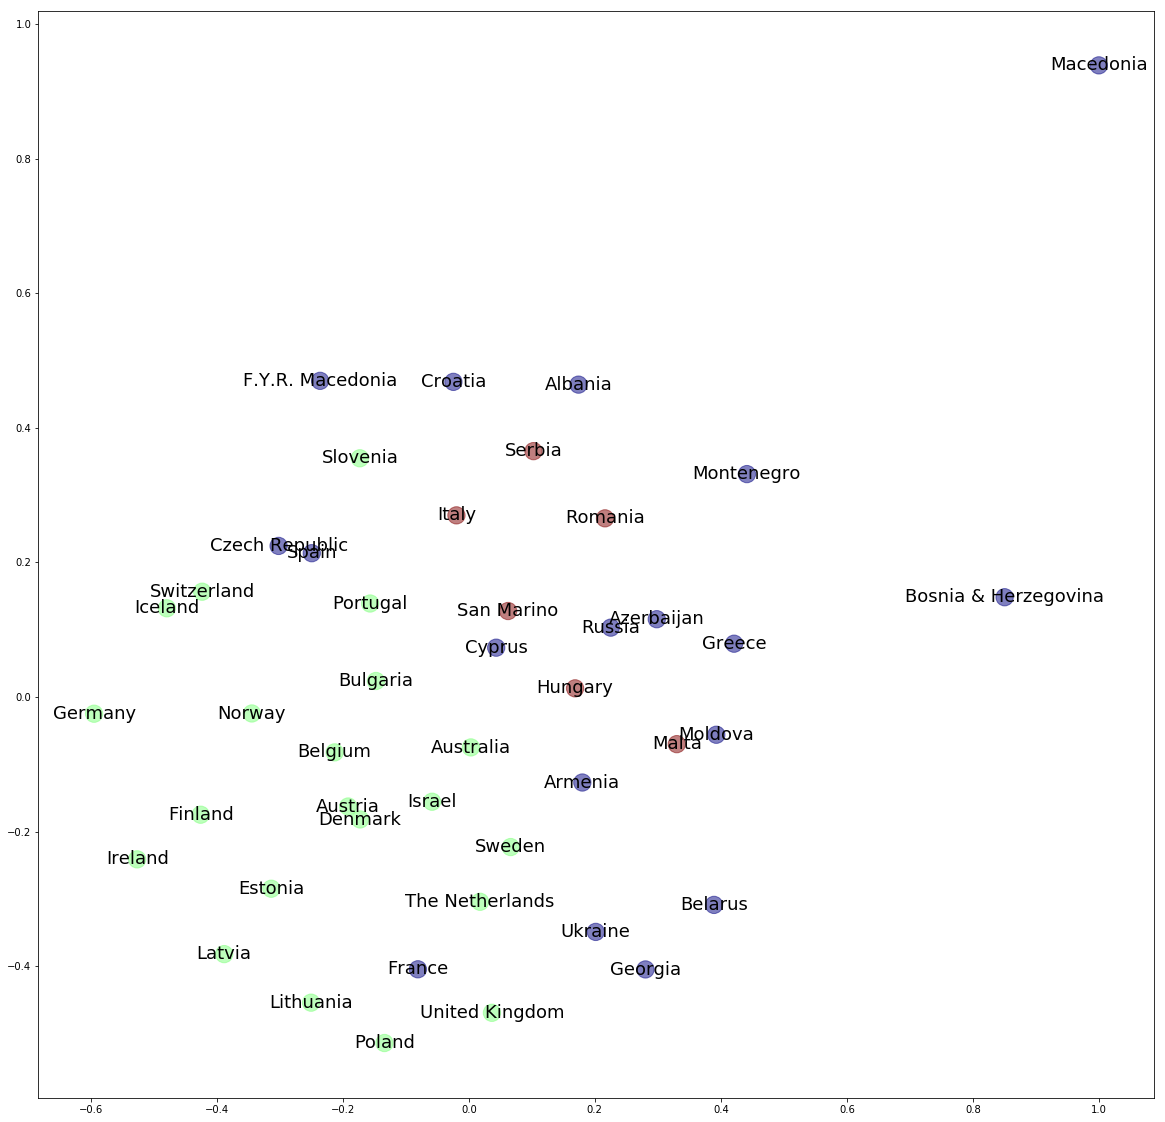

In [132]:
part,graph = detect_community(df_votes,2013,2018)
visualise(part,graph)

# Anlaysis using Jaccard similarity between communities to detect change over time

In [17]:

import scipy.stats



def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    #print(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection / union)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h



def av_jaccard(current_year, prev_year):
    
    graph_prev, part_prev = detect_community(df_votes,prev_year,prev_year)
    graph_current, part_current = detect_community(df_votes,current_year,current_year)
    
    clusters_prev = pd.Series(part_prev, name='prev').unique()
    clusters_current = pd.Series(part_current, name='current').unique()

    matches =[]

    for i in np.nditer(clusters_current):
        A = pd.Series(part_current)
        A = A[A==i].index.astype(list)

        compare = []
        for j in np.nditer(clusters_prev):
            B = pd.Series(part_prev)
            B = B[B==j].index.astype(list)
            compare.append(jaccard_similarity(A,B))
            best_match = (max(compare))

        matches.append((best_match,len(A)))

       
    
    wieghted_score = np.sum([x*y for x,y in matches])
    denominator = np.sum([y for x,y in matches])
    wieghted_av_jaccard = wieghted_score/denominator
    
    return wieghted_av_jaccard

def av_jaccard_2(year,window):
    
    graph_prev, part_prev = detect_community(df_votes,year-window-1,year-1) #community composed of last 'window' years
    graph_current, part_current = detect_community(df_votes,year,year)
    
    clusters_prev = pd.Series(part_prev, name='prev').unique()
    clusters_current = pd.Series(part_current, name='current').unique()

    matches =[]

    for i in np.nditer(clusters_current):
        A = pd.Series(part_current)
        A = A[A==i].index.astype(list)

        compare = []
        for j in np.nditer(clusters_prev):
            B = pd.Series(part_prev)
            B = B[B==j].index.astype(list)
            compare.append(jaccard_similarity(A,B))
            best_match = (max(compare))

        matches.append((best_match,len(A)))

       
    
    wieghted_score = np.sum([x*y for x,y in matches])
    denominator = np.sum([y for x,y in matches])
    wieghted_av_jaccard = wieghted_score/denominator
    
    return wieghted_av_jaccard
 
def rolling_jaccard(start,end):
    df_jac = pd.DataFrame(columns=['distance','+95%CI','-95%CI'])
    for year in np.arange(start,end+1,1):
       
        print("\r Processing: " + str(year), end = "")
        jacs = []
        for i in range(10):
            jacs.append(av_jaccard(year-1,year))
        av_jac = np.mean(jacs)
        conf_jac = mean_confidence_interval(jacs)
        df_jac.loc[year,'distance']=av_jac
        df_jac.loc[year,'+95%CI']=av_jac+conf_jac
        df_jac.loc[year,'-95%CI']=av_jac-conf_jac
        

    return df_jac

def rolling_jaccard_2(start,end,n=30,window=5):
    df_jac = pd.DataFrame(columns=['distance','+95%CI','-95%CI'])
    for year in np.arange(start,end+1,1):
        print("\r Processing: " + str(year), end = "")
        jacs = []
        for i in range(n):
            jacs.append(av_jaccard_2(year,window))
        av_jac = np.mean(jacs)
        conf_jac = mean_confidence_interval(jacs)
        df_jac.loc[year,'distance']=av_jac
        df_jac.loc[year,'+95%CI']=av_jac+conf_jac
        df_jac.loc[year,'-95%CI']=av_jac-conf_jac
        

    return df_jac

In [47]:
df_jac_pre = rolling_jaccard(1990,2018)

processing 1990
processing 1991
processing 1992
processing 1993
processing 1994
processing 1995
processing 1996
processing 1997
processing 1998
processing 1999
processing 2000
processing 2001
processing 2002
processing 2003
processing 2004
processing 2005
processing 2006
processing 2007
processing 2008
processing 2009
processing 2010
processing 2011
processing 2012
processing 2013
processing 2014
processing 2015
processing 2016
processing 2017
processing 2018


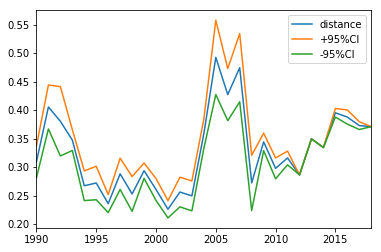

In [48]:
df_jac_pre.plot()

In [624]:
df_jac_pre_2 = rolling_jaccard_2(1990,2018)

 Processing: 2018

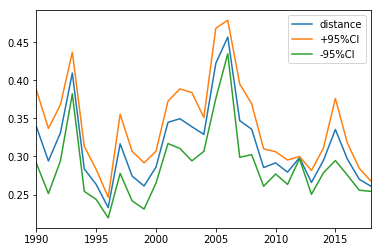

In [69]:
df_jac_pre_2.plot()

In [75]:

df_jac_3 = rolling_jaccard_2(1995,2018,n=30,window=5)

processing 1995
processing 1996
processing 1997
processing 1998
processing 1999
processing 2000
processing 2001
processing 2002
processing 2003
processing 2004
processing 2005
processing 2006
processing 2007
processing 2008
processing 2009
processing 2010
processing 2011
processing 2012
processing 2013
processing 2014
processing 2015
processing 2016
processing 2017
processing 2018


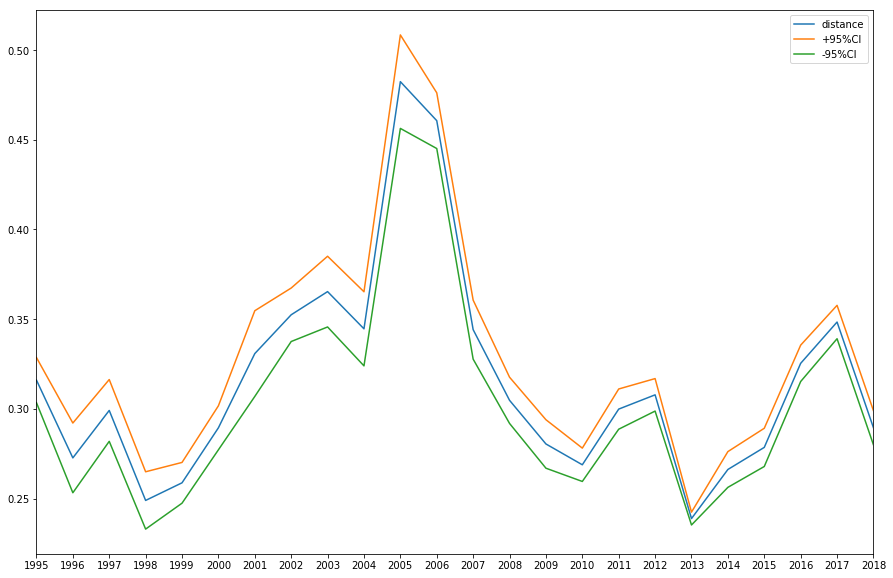

In [76]:

df_jac_3.plot(xticks=df_jac_3.index,figsize=(15,10))

In [125]:
part_test,graph_test=detect_community(df_votes,1999,2000)
part_test2,graph_test2=detect_community(df_votes,2005,2006)

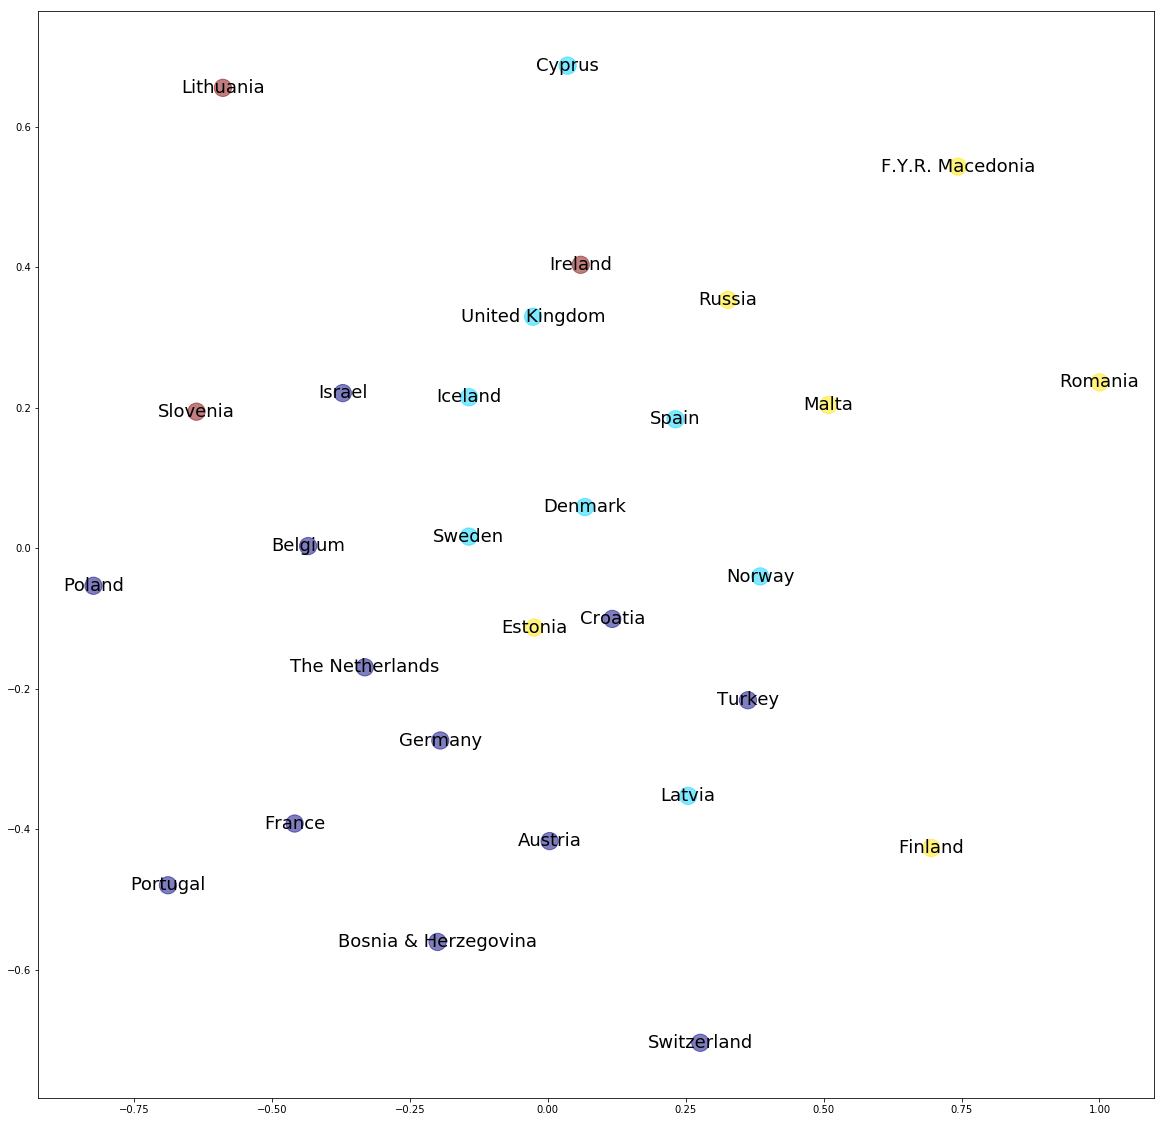

In [126]:
visualise(part_test,graph_test)

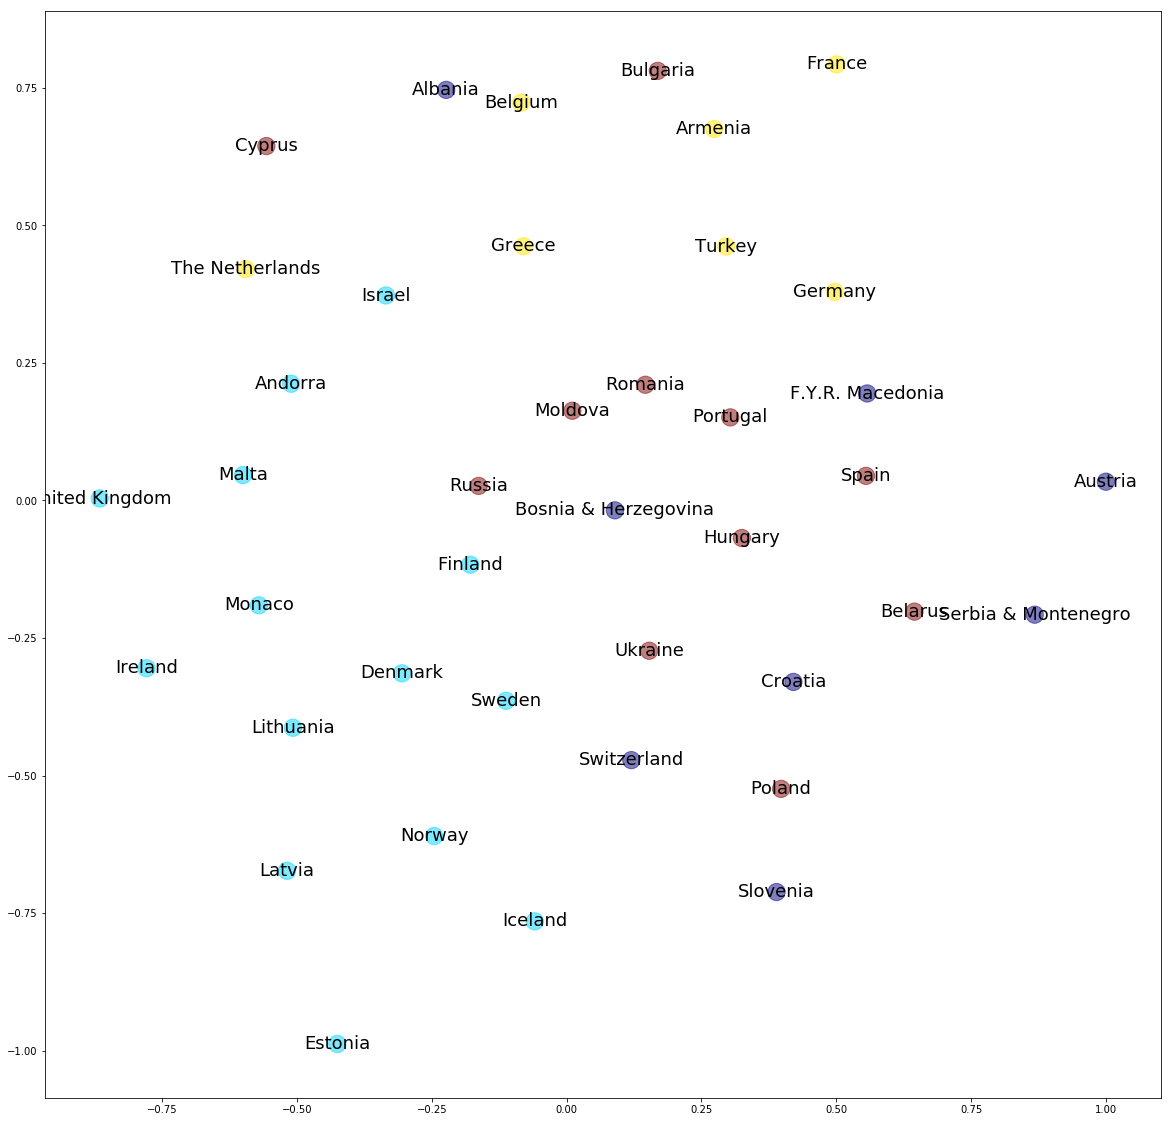

In [127]:
visualise(part_test2,graph_test2)

In [ ]:
# for a range of years:

#creat and expected array



## A frequentist Approach

Approach adapted from:  

Derek Gatherer(2006) Comparison of Eurovision Song Contest Simulation with Actual Results Reveals Shifting Patterns of Collusive Voting Alliances. Journal of Artificial Societies and Social Simulation vol. 9, no. 2
http://jasss.soc.surrey.ac.uk/9/2/1.html


In [154]:



def get_vote_dist(year):  #construct distribution
    # N.B: Effective for year 1975 to 2015
    
    # count number of voters in that year
    voters = len(df_votes[df_votes['Year']==year].groupby('From country').sum().index)
    # subtract 1 to account for no voting for self
    available_votes = voters - 1 
    # calcualte vote probabilities
    p_non_zero = 1/available_votes
    p_zero     = (available_votes-10)/available_votes
    #creat distribution
    vote_values = [0,1,2,3,4,5,6,7,8,10,12]
    vote_proba  = np.append([p_zero],np.full((10), p_non_zero))
    
    return (vote_values,vote_proba)



def simulate_voting(start_year,end_year,simulations): # monte-carlo simulation for n years
    mean_dist = []
    for i in range(simulations):
        print("\r Similation: "+str(i)+" of "+str(simulations), end = "")
        votes = []

        for year in np.arange(start_year,end_year,1):

            vote_values,vote_proba = get_vote_dist(year)    # get vote probability distribution for current year
            vote_sample = np.random.choice(vote_values, 1,p=vote_proba) # sample from distribution
            votes.append(vote_sample)   # append sample to list

        mean_sample = np.mean(votes)    
        mean_dist.append(mean_sample)
        
    return(mean_dist)

def get_threshold(mean_dist,p_val):
    #fig, ax = plt.subplots(1, 1)
    #plt.hist(mean_dist,bins=200)
    threshold = np.percentile(mean_dist, p_val)
    mean = np.percentile(mean_dist, 50)
    #ax.axvline(x=threshold, c='red', alpha=1, linestyle='--')
    #ax.axvline(x=mean, c='blue', alpha=1, linestyle='--')
    #plt.show()
    return (threshold)


def detect_coalitions(df,test_stat,start_year,end_year): 

    # generate real values for these years 

    selected_df = df[df['Year'].between(start_year,end_year)]
    selected_df = selected_df.groupby(['From country','To country']).Points.mean()
    selected_df = selected_df.unstack().fillna(0)
    
    loosers = list(set(selected_df.index)-set(selected_df.columns))
    for i in range(len(loosers)):
        selected_df[loosers[i]] = 0

    #detect suspect preferential voting
    suspect = lambda x : x > test_stat
    suspect_df = selected_df.apply(suspect)

    coalitions= pd.DataFrame(columns=['CountryA','CountryB','Start year','End year','Av_voters'])
    coalition_count = 0

    # detect reciprocity

    for countryA in suspect_df.index:    
        for countryB in suspect_df.index:
            if suspect_df.loc[countryA,countryB] == True:
                if suspect_df.loc[countryB,countryA] == True:
                    coalition_count += 1
                    coalitions.loc[coalition_count,'CountryA'] = countryA
                    coalitions.loc[coalition_count,'CountryB'] = countryB

    #remove directionality
    dupes = coalitions[['CountryA','CountryB']].T.apply(sorted).T.duplicated()

    coalitions = coalitions[~dupes]
    coalitions.loc[:,'Start year'] = start_year
    coalitions.loc[:,'End year'] = end_year
    coalitions.loc[:,'Av_voters']  = df_votes[df_votes['Year'].between(start_year,end_year)].groupby('Year').nunique().loc[:,'From country'].mean()

    
    return (coalitions)

def visualise_df(coalitions_df,size):
    
    #draw results
    g_coalitions=nx.from_pandas_edgelist(coalitions_df,'CountryA','CountryB')

    plt.figure(figsize=(size,size))
    nx.draw(g_coalitions,with_labels=True,font_size=30)
    
    return

# Test monte-carlo simulation : Inspect resulting distribution

In [82]:
vote_values,vote_proba = get_vote_dist(2000)

<BarContainer object of 11 artists>

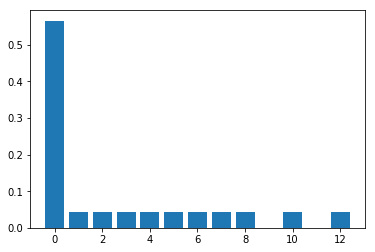

In [83]:
plt.bar(vote_values,vote_proba)

In [138]:
np.sum(vote_proba)

0.9999999999999999

In [74]:
test_dist = simulate_voting(2000,2005,2000)

 Similation: 1999 of 2000

(array([375., 389., 397., 359., 239., 145.,  53.,  28.,  11.,   4.]),
 array([0.  , 0.84, 1.68, 2.52, 3.36, 4.2 , 5.04, 5.88, 6.72, 7.56, 8.4 ]),
 <a list of 10 Patch objects>)

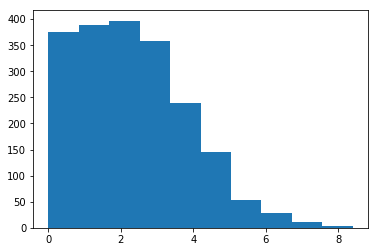

In [75]:
plt.hist(test_dist)

In [137]:
np.average(test_dist)

2.3189

In [20]:
def analyse_period (df,start,end,simulations,threshold):
    """ 
    1) simulates voting for specified period
    2) compares simulated voting with actual voting to detect outliers (favouratism)
    3) detects reciprocal favouratism (alliances)
    
    
    Parameters:
    
    df: df of votes to be analysed
    start: start year to be assessed
    end: end year of period
    simulations: number of runs on monte-carlo to be simulated
    threshold : percentile to be considered favouratism

    """


    dist= simulate_voting(start,end,simulations) #simulate voting in period
    test_stat = get_threshold(dist, threshold) #calculate test statitic for given percentile
    coalitions= detect_coalitions(df,test_stat,start,end) #detect coalitions

    
    return(coalitions)

In [76]:

# def analyse_data(df,start_year,end_year,period,simulations,threshold):

simulations = 2000
threshold = 90
coalitions_1975_1980 = analyse_period(df_votes,1975,1980,simulations,threshold)
coalitions_1980_1985 = analyse_period(df_votes,1980,1985,simulations,threshold)
coalitions_1985_1990 = analyse_period(df_votes,1985,1990,simulations,threshold)
coalitions_1990_1995 = analyse_period(df_votes,1990,1995,simulations,threshold)
coalitions_1995_2000 = analyse_period(df_votes,1995,2000,simulations,threshold)
coalitions_2000_2005 = analyse_period(df_votes,2000,2005,simulations,threshold)
coalitions_2005_2010 = analyse_period(df_votes,2005,2010,simulations,threshold)
coalitions_2010_2015 = analyse_period(df_votes,2010,2015,simulations,threshold)
coalitions = coalitions_1980_1985.append([coalitions_1975_1980,coalitions_1985_1990 ,coalitions_1990_1995,coalitions_1995_2000,coalitions_2000_2005,coalitions_2005_2010,coalitions_2010_2015]).reset_index(drop=True)


 Similation: 1999 of 2000

In [124]:
## Analyse finalists only

In [22]:
end=2015
div = 3
start=1975
simulations = 2000
threshold = 90
span =end-start
test = int(span/div)
a_nu_start = 2015 - (div*test)

starts = np.arange(a_nu_start,end,div)
coalitions= pd.DataFrame(columns=['CountryA','CountryB','Start year','End year','Av_voters'])
initialise = 0

for year in starts:
    initialise += 1
    coalition = analyse_period(df_votes_finals,year,year+div,simulations,threshold)
    coalitions = coalitions.append(coalition).reset_index(drop=True)
        
    
    

 Similation: 199 of 200

In [23]:
coalitions

,CountryA,CountryB,Start year,End year,Av_voters
0,Belgium,United Kingdom,1976,1979,18.75
1,France,Greece,1976,1979,18.75
2,Ireland,Italy,1976,1979,18.75
3,Germany,Ireland,1979,1982,19.00
4,Ireland,Switzerland,1979,1982,19.00
5,Italy,Portugal,1979,1982,19.00
6,Italy,Spain,1979,1982,19.00
7,Switzerland,United Kingdom,1979,1982,19.00
8,Ireland,Sweden,1982,1985,19.00
9,Israel,Luxembourg,1982,1985,19.00


In [24]:
connections = coalitions.groupby('Start year').count().loc[:,'CountryA'] # number of reciprocal relationships
countries = coalitions.groupby('Start year').nunique().loc[:,'CountryA'] # number of countries in a coalition



In [25]:
summary=pd.DataFrame(columns=['Deals Made','Countries in Deals','Average Countries in Period','Total Possible Deals'],index=connections.index)

In [26]:
voters = []
for year in summary.index:
    voters.append(coalitions[coalitions['Start year']==year].loc[:,'Av_voters'].unique()[0])
voters = np.asarray(voters)
possible_connect = (voters*(voters-1))/2
possible_connect = possible_connect.astype(int) #average possible connections in year  
    
summary['Deals Made']=connections
summary['Countries in Deals']=countries
summary['Average Countries in Period']= voters
summary['Total Possible Deals'] = possible_connect
summary['Percentage countries in deal'] = summary.apply(lambda row: row['Countries in Deals'] / row['Average Countries in Period'], axis=1)
summary['Normalised deal-making'] = summary.apply(lambda row: row['Deals Made'] / row['Total Possible Deals'], axis=1)

In [27]:
summary

,Deals Made,Countries in Deals,Average Countries in Period,Total Possible Deals,Percentage countries in deal,Normalised deal-making
Start year,,,,,,
1976,3,3,18.75,166,0.160000,0.018072
1979,5,4,19.00,171,0.210526,0.029240
1982,3,3,19.00,171,0.157895,0.017544
1985,3,2,20.50,199,0.097561,0.015075
1988,5,3,21.75,225,0.137931,0.022222
1991,17,9,23.75,270,0.378947,0.062963
1994,18,11,24.00,276,0.458333,0.065217
1997,23,14,24.25,281,0.577320,0.081851
2000,17,12,24.25,281,0.494845,0.060498


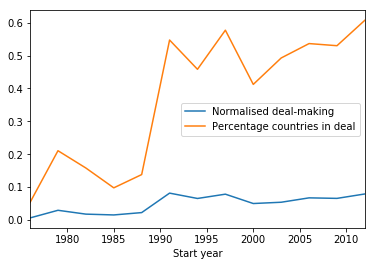

In [703]:
summary[['Normalised deal-making','Percentage countries in deal']].plot()

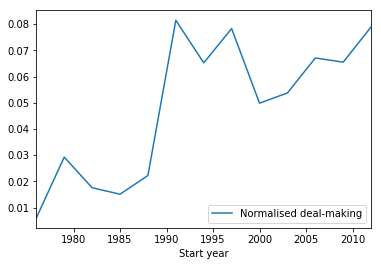

In [704]:
summary[['Normalised deal-making']].plot()

In [ ]:
summary['Normalised deal-making'].plot()

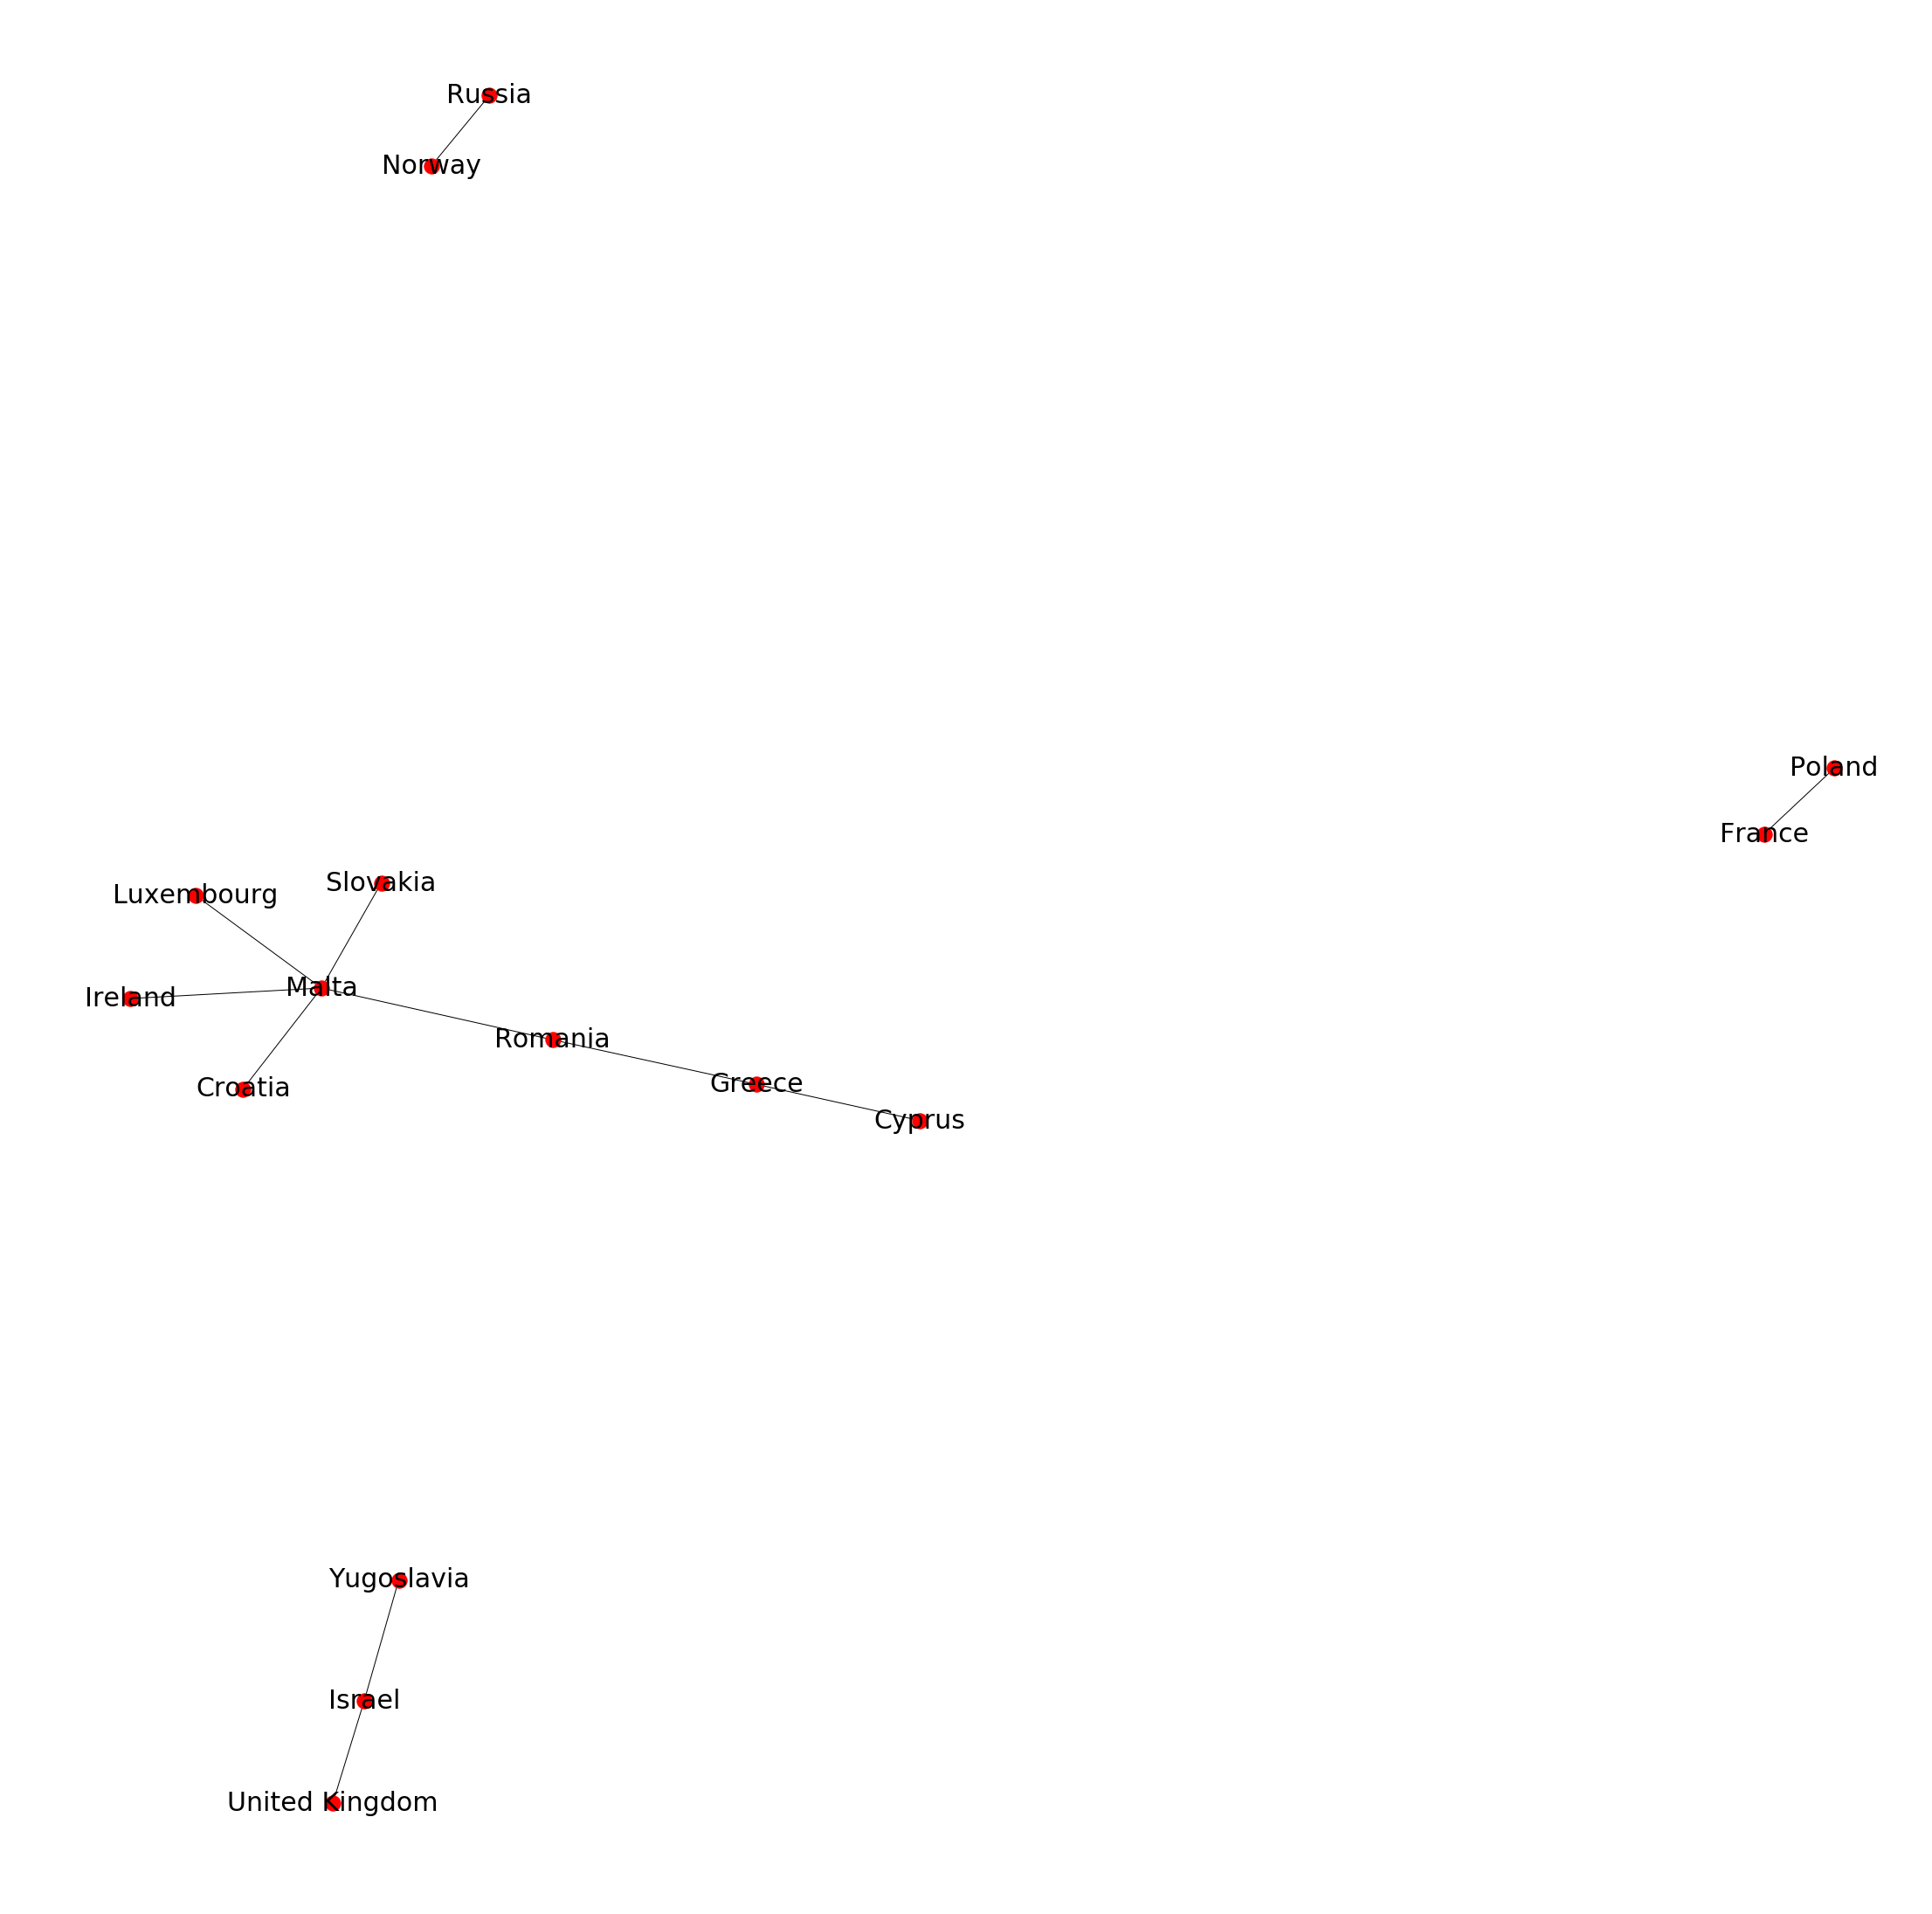

In [162]:


visualise_df(coalitions_1990_1995,30) #visualise

In [161]:
coalitions_1995_2000

,CountryA,CountryB,Start year,End year,Av_voters
1,Croatia,F.Y.R. Macedonia,1995,2000,23.833333
2,Croatia,Malta,1995,2000,23.833333
3,Cyprus,Greece,1995,2000,23.833333
4,Denmark,Iceland,1995,2000,23.833333
5,Denmark,Latvia,1995,2000,23.833333
6,Denmark,Sweden,1995,2000,23.833333
7,Estonia,Finland,1995,2000,23.833333
8,Estonia,Latvia,1995,2000,23.833333
9,Estonia,Sweden,1995,2000,23.833333
11,F.Y.R. Macedonia,Romania,1995,2000,23.833333
